# UMAP
In the first step, I load bo the clinical metadata, the collapsed dataset (that was not zscored), and the z-scored dataset.

In [75]:
import os
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# Load environment variables and find repo root
load_dotenv(dotenv_path="/Users/sarah/Code/bioinformatics-tool/analysis/.env")

def find_repo_root(start_path: Path = None) -> Path:
    if start_path is None:
        start_path = Path().resolve()
    for parent in [start_path] + list(start_path.parents):
        if (parent / '.git').exists():
            return parent
    raise RuntimeError("Could not find repo root!")

repo_root = find_repo_root()

# Load clinical data
clinical_path = repo_root / os.getenv("CLINICAL")
clinical_df = pd.read_csv(clinical_path, index_col=0)

clinical_path = repo_root / os.getenv("CLINICAL_IMPUTED")
clinical_df_imputed = pd.read_csv(clinical_path, index_col=0)

# Load expression (z-scored) data
zscored_path = repo_root / os.getenv("ZSCORED_QUALITY_CHECKED")
zscored_df = pd.read_csv(zscored_path, index_col=0)

# Make sure both dataframes have the same samples and are in the same order
common_samples = clinical_df.index.intersection(zscored_df.index)
clinical_df = clinical_df.loc[common_samples]
zscored_df = zscored_df.loc[common_samples]


collapsed_path = repo_root / os.getenv("EM_COLLAPSED")
collapsed_df = pd.read_csv(collapsed_path, index_col=0)

common_samples = clinical_df.index.intersection(collapsed_df.index)
clinical_df = clinical_df.loc[common_samples]
collapsed_df = collapsed_df.loc[common_samples]

print(f"Zscored data shape: {zscored_df.shape}")
print(f"Collapsed (not zscored) data shape: {collapsed_df.shape}")
print(f"Clinical data shape: {clinical_df.shape}")

Zscored data shape: (3273, 26150)
Collapsed (not zscored) data shape: (3273, 26150)
Clinical data shape: (3273, 34)


In [76]:
print(f"Clinical data shape: {clinical_df.shape}")
print(f"Collapsed data shape: {collapsed_df.shape}")

Clinical data shape: (3273, 34)
Collapsed data shape: (3273, 26150)


## Z-Scored

/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


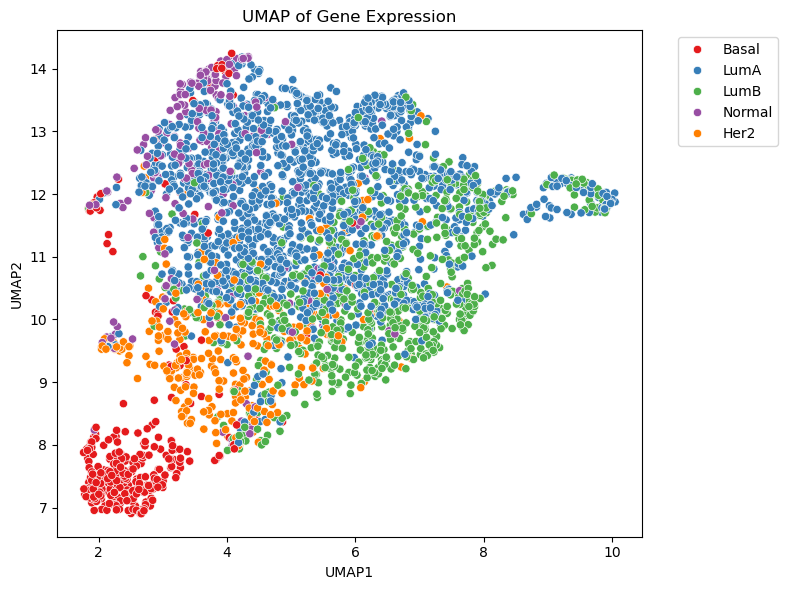

In [77]:
reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = reducer.fit_transform(zscored_df.values)

umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'], index=zscored_df.index)
umap_df = umap_df.join(clinical_df)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='UMAP1', y='UMAP2', 
    data=umap_df, 
    hue='OG_pam50 subtype',    
    palette='Set1'
)
plt.title('UMAP of Gene Expression')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [78]:
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder

label_col = 'OG_pam50 subtype'
labels = LabelEncoder().fit_transform(clinical_df[label_col].astype(str))
sil_umap = silhouette_score(umap_result, labels)
print(f"UMAP Silhouette Score (w.r.t {label_col}): {sil_umap:.3f}")


UMAP Silhouette Score (w.r.t OG_pam50 subtype): 0.017


In [79]:
from scipy.stats import f_oneway, kruskal

# UMAP1 axis
groups1 = [umap_df['UMAP1'][umap_df[label_col] == g].values for g in umap_df[label_col].unique()]
anova_umap1 = f_oneway(*groups1).pvalue
print(f"ANOVA p-value for UMAP1 between {label_col} groups: {anova_umap1:.3e}")

# UMAP2 axis
groups2 = [umap_df['UMAP2'][umap_df[label_col] == g].values for g in umap_df[label_col].unique()]
anova_umap2 = f_oneway(*groups2).pvalue
print(f"ANOVA p-value for UMAP2 between {label_col} groups: {anova_umap2:.3e}")


ANOVA p-value for UMAP1 between OG_pam50 subtype groups: 0.000e+00
ANOVA p-value for UMAP2 between OG_pam50 subtype groups: 0.000e+00


In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

clf = LogisticRegression(max_iter=1000, multi_class='multinomial')
scores = cross_val_score(clf, umap_result, labels, cv=5)
print(f"Logistic Regression accuracy on UMAP embedding: {scores.mean():.3f} ± {scores.std():.3f}")


/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: Futur

Logistic Regression accuracy on UMAP embedding: 0.672 ± 0.010


In [81]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import numpy as np

kmeans = KMeans(n_clusters=len(np.unique(labels)), random_state=42).fit(umap_result)
ari = adjusted_rand_score(labels, kmeans.labels_)
print(f"Adjusted Rand Index (ARI) between k-means clusters and {label_col}: {ari:.3f}")


Adjusted Rand Index (ARI) between k-means clusters and OG_pam50 subtype: 0.143


## Collapsed

In [82]:
N = 8000  # or another number you prefer
gene_variances = collapsed_df.var(axis=0)
top_genes = gene_variances.sort_values(ascending=False).head(N).index
collapsed_df = collapsed_df[top_genes]


/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


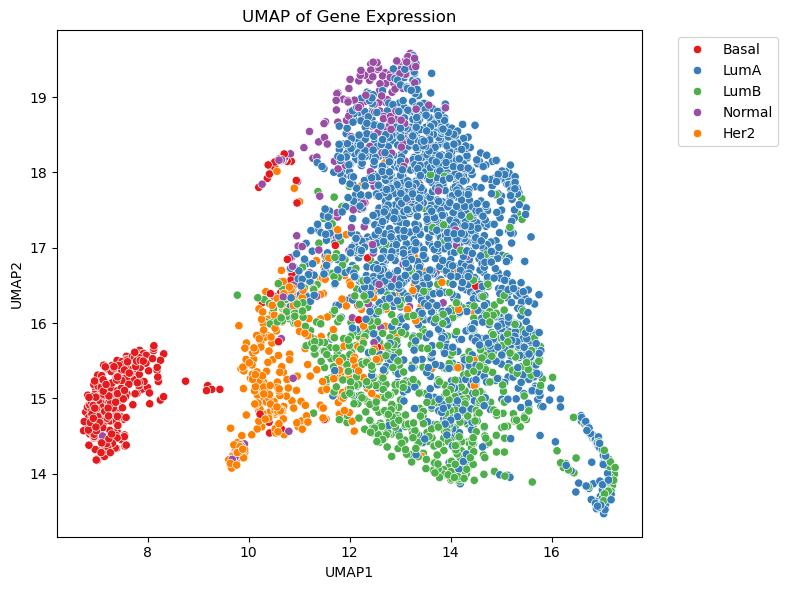

In [83]:
reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = reducer.fit_transform(collapsed_df.values)

umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'], index=collapsed_df.index)
umap_df = umap_df.join(clinical_df)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='UMAP1', y='UMAP2', 
    data=umap_df, 
    hue='OG_pam50 subtype',    
    palette='Set1'
)
plt.title('UMAP of Gene Expression')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [84]:
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder

label_col = 'OG_pam50 subtype'
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(clinical_df[label_col].astype(str))
sil_umap = silhouette_score(umap_result, labels)
print(f"UMAP Silhouette Score (w.r.t {label_col}): {sil_umap:.3f}")


UMAP Silhouette Score (w.r.t OG_pam50 subtype): 0.082


In [85]:
from scipy.stats import f_oneway, kruskal

# UMAP1 axis
groups1 = [umap_df['UMAP1'][umap_df[label_col] == g].values for g in umap_df[label_col].unique()]
anova_umap1 = f_oneway(*groups1).pvalue
print(f"ANOVA p-value for UMAP1 between {label_col} groups: {anova_umap1:.3e}")

# UMAP2 axis
groups2 = [umap_df['UMAP2'][umap_df[label_col] == g].values for g in umap_df[label_col].unique()]
anova_umap2 = f_oneway(*groups2).pvalue
print(f"ANOVA p-value for UMAP2 between {label_col} groups: {anova_umap2:.3e}")


ANOVA p-value for UMAP1 between OG_pam50 subtype groups: 0.000e+00
ANOVA p-value for UMAP2 between OG_pam50 subtype groups: 0.000e+00


In [86]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

kmeans = KMeans(n_clusters=len(np.unique(labels)), random_state=42).fit(umap_result)
ari = adjusted_rand_score(labels, kmeans.labels_)
print(f"Adjusted Rand Index (ARI) between k-means clusters and {label_col}: {ari:.3f}")


Adjusted Rand Index (ARI) between k-means clusters and OG_pam50 subtype: 0.276


## Combine with Supervised ML

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

clf = LogisticRegression(max_iter=1000, multi_class='multinomial')
scores = cross_val_score(clf, umap_result, labels, cv=5)
print(f"Logistic Regression accuracy on UMAP embedding: {scores.mean():.3f} ± {scores.std():.3f}")


/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: Futur

Logistic Regression accuracy on UMAP embedding: 0.733 ± 0.008


In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Define classifier (swap out for SVM, XGBoost, etc. as needed)
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# ---- Cross-Validation (CV) ----
cv_scores = cross_val_score(clf, umap_result, labels, cv=5)
print(f"Random Forest CV accuracy on UMAP embedding: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# ---- Train/Test Split ----
X_train, X_test, y_train, y_test = train_test_split(
    umap_result, labels, test_size=0.2, random_state=42, stratify=labels
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print(f"Random Forest test set accuracy on UMAP embedding: {test_acc:.3f}")
print("Classification report on test set:\n", classification_report(y_test, y_pred))


Random Forest CV accuracy on UMAP embedding: 0.735 ± 0.014
Random Forest test set accuracy on UMAP embedding: 0.750
Classification report on test set:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90        68
           1       0.69      0.65      0.67        65
           2       0.78      0.85      0.81       332
           3       0.67      0.62      0.64       146
           4       0.52      0.36      0.43        44

    accuracy                           0.75       655
   macro avg       0.72      0.67      0.69       655
weighted avg       0.74      0.75      0.74       655




Random Forest CV accuracy on UMAP embedding: 0.735 ± 0.014

Random Forest test set accuracy on UMAP embedding: 0.750

Classification Report:
               precision  recall  f1-score  support
0                 0.923   0.882     0.902    68.00
1                 0.689   0.646     0.667    65.00
2                 0.777   0.852     0.813   332.00
3                 0.672   0.616     0.643   146.00
4                 0.516   0.364     0.427    44.00
accuracy          0.750   0.750     0.750     0.75
macro avg         0.715   0.672     0.690   655.00
weighted avg      0.743   0.750     0.744   655.00


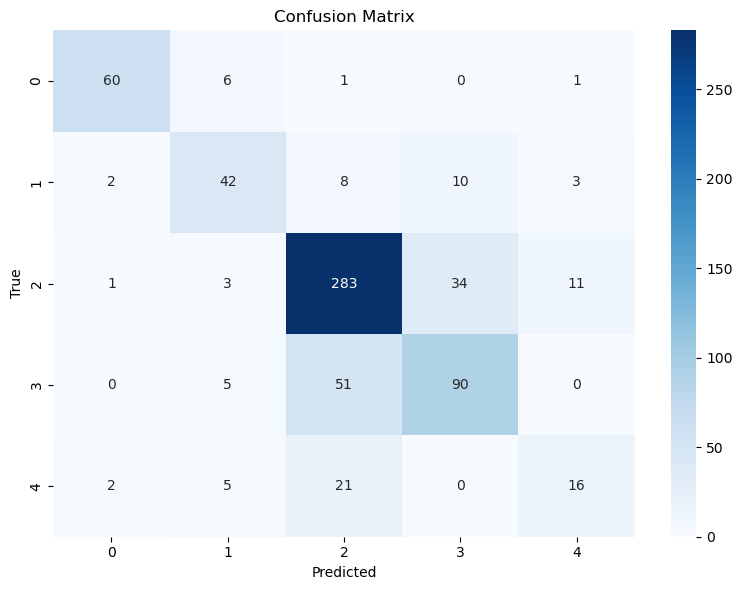

In [89]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

clf = RandomForestClassifier(n_estimators=100, random_state=42)

# ---- Cross-Validation (CV) ----
cv_scores = cross_val_score(clf, umap_result, labels, cv=5)
print(f"\nRandom Forest CV accuracy on UMAP embedding: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# ---- Train/Test Split ----
X_train, X_test, y_train, y_test = train_test_split(
    umap_result, labels, test_size=0.2, random_state=42, stratify=labels
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)

print(f"\nRandom Forest test set accuracy on UMAP embedding: {test_acc:.3f}\n")

# ---- Classification Report ----
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
print("Classification Report:\n", report_df.round(3))

# Optional: Save to CSV/Excel/Markdown
# report_df.to_csv("classification_report.csv")
# report_df.to_markdown("classification_report.md")

# ---- Confusion Matrix ----
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


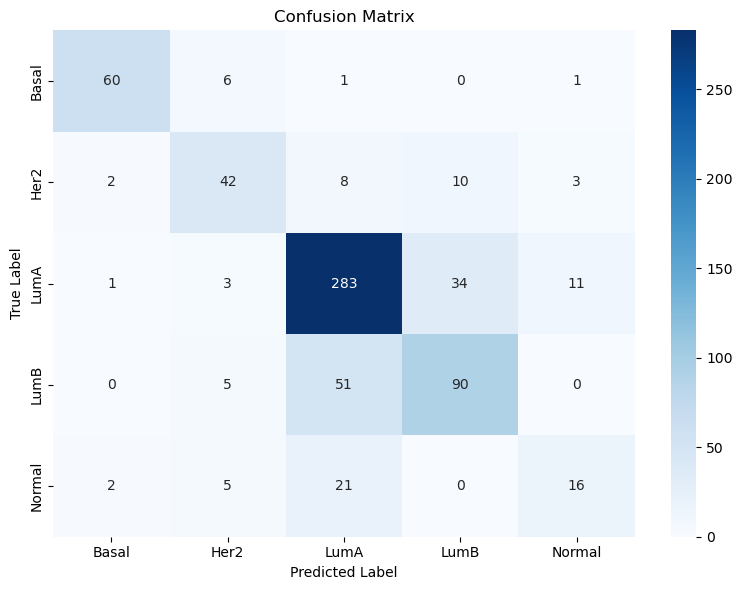

In [91]:
# Assuming you used LabelEncoder for labels:
from sklearn.preprocessing import LabelEncoder

# Example (if you already did this):
# label_encoder = LabelEncoder()
# labels = label_encoder.fit_transform(clinical_df['OG_pam50 subtype'].astype(str))
# Then you trained/tested as above

class_names = label_encoder.classes_  # Get the original class names

# Confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=class_names, yticklabels=class_names
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [92]:
from sklearn.metrics import classification_report

# Print classification report with class names
print(classification_report(y_test, y_pred, target_names=class_names))


              precision    recall  f1-score   support

       Basal       0.92      0.88      0.90        68
        Her2       0.69      0.65      0.67        65
        LumA       0.78      0.85      0.81       332
        LumB       0.67      0.62      0.64       146
      Normal       0.52      0.36      0.43        44

    accuracy                           0.75       655
   macro avg       0.72      0.67      0.69       655
weighted avg       0.74      0.75      0.74       655



### Combined with Full Df

In [ ]:
clinical_df.columns

Index(['OG_last_update_date', 'OG_instrument model', 'age at diagnosis',
       'tumor size', 'lymph node group', 'lymph node status', 'er status',
       'pgr status', 'her2 status', 'ki67 status', 'nhg', 'er prediction mgc',
       'pgr prediction mgc', 'her2 prediction mgc', 'ki67 prediction mgc',
       'nhg prediction mgc', 'er prediction sgc', 'pgr prediction sgc',
       'her2 prediction sgc', 'ki67 prediction sgc', 'OG_pam50 subtype',
       'overall survival days', 'overall survival event', 'endocrine treated',
       'chemo treated', 'OHE_last_update_date__Mar 12 2018',
       'OHE_last_update_date__May 04 2022', 'OHE_instrument model__HiSeq 2000',
       'OHE_instrument model__NextSeq 500', 'OHE_pam50 subtype__Basal',
       'OHE_pam50 subtype__Her2', 'OHE_pam50 subtype__LumA',
       'OHE_pam50 subtype__LumB', 'OHE_pam50 subtype__Normal'],
      dtype='object')

In [ ]:
collapsed_df.shape

(3273, 26150)

In [ ]:
clinical_df_imputed.shape

(3409, 35)

In [ ]:
# If the sample names are in the index:
mask = ~clinical_df_imputed.index.str.contains('rep')
clinical_df_imputed = clinical_df_imputed[mask]


In [ ]:
clinical_df_imputed.shape

(3273, 35)

/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


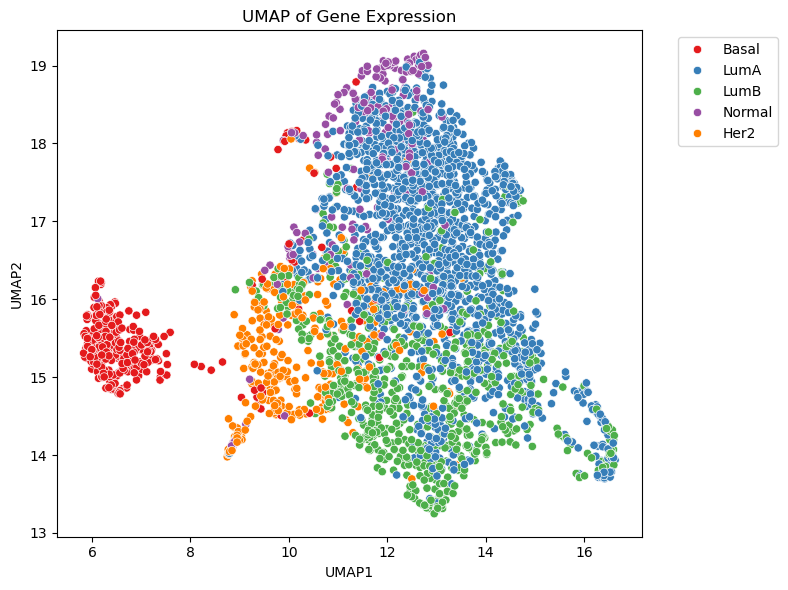

In [ ]:
reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = reducer.fit_transform(collapsed_df.values)

umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'], index=collapsed_df.index)
umap_df = umap_df.join(clinical_df_imputed)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='UMAP1', y='UMAP2', 
    data=umap_df, 
    hue='OG_pam50 subtype',    
    palette='Set1'
)
plt.title('UMAP of Gene Expression')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# If umap_result is a numpy array:
umap_df = pd.DataFrame(umap_result, columns=['UMAP1', 'UMAP2'], index=clinical_df_imputed.index)



cols_to_drop = ['OG_last_update_date', 'OG_instrument model', 
       'er prediction mgc',
       'pgr prediction mgc', 'her2 prediction mgc', 'ki67 prediction mgc',
       'nhg prediction mgc', 'er prediction sgc', 'pgr prediction sgc',
       'her2 prediction sgc', 'ki67 prediction sgc', 'OG_pam50 subtype',
       'overall survival days', 'overall survival event', 'endocrine treated',
       'chemo treated', 'OHE_last_update_date__Mar 12 2018',
       'OHE_last_update_date__May 04 2022', 'OHE_instrument model__HiSeq 2000',
       'OHE_instrument model__NextSeq 500', 'OHE_pam50 subtype__Basal',
       'OHE_pam50 subtype__Her2', 'OHE_pam50 subtype__LumA',
       'OHE_pam50 subtype__LumB', 'OHE_pam50 subtype__Normal']

clinical_features = clinical_df_imputed.drop(columns=cols_to_drop, errors='ignore')



# Combine UMAP and clinical features
X_full = pd.concat([umap_df, clinical_features], axis=1)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Use the same labels as before
# If you haven't already encoded labels:
from sklearn.preprocessing import LabelEncoder
labels = LabelEncoder().fit_transform(clinical_df_imputed['OG_pam50 subtype'].astype(str))

clf = RandomForestClassifier(n_estimators=100, random_state=42)

# ---- Cross-Validation (CV) ----
cv_scores = cross_val_score(clf, X_full, labels, cv=5)
print(f"Random Forest CV accuracy (UMAP + clinical): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# ---- Train/Test Split ----
X_train, X_test, y_train, y_test = train_test_split(
    X_full, labels, test_size=0.2, random_state=42, stratify=labels
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)
print(f"Random Forest test set accuracy (UMAP + clinical): {test_acc:.3f}")
print("Classification report on test set:\n", classification_report(y_test, y_pred))


Random Forest CV accuracy (UMAP + clinical): 0.761 ± 0.010
Random Forest test set accuracy (UMAP + clinical): 0.777
Classification report on test set:
               precision    recall  f1-score   support

           0       0.92      0.85      0.89        68
           1       0.79      0.75      0.77        65
           2       0.80      0.87      0.83       332
           3       0.66      0.69      0.68       146
           4       0.71      0.27      0.39        44

    accuracy                           0.78       655
   macro avg       0.78      0.69      0.71       655
weighted avg       0.78      0.78      0.77       655



In [ ]:
X_full.isna().sum()

UMAP1                136
UMAP2                136
age at diagnosis       0
tumor size             0
lymph node group       0
lymph node status      0
er status              0
pgr status             0
her2 status            0
ki67 status            0
nhg                    0
ki67_measured          0
dtype: int64

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, multi_class='multinomial'),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
}

for name, model in models.items():
    scores = cross_val_score(model, X_full, labels, cv=5)
    print(f"{name}: {scores.mean():.3f} ± {scores.std():.3f}")


Random Forest: 0.761 ± 0.010
SVM: 0.597 ± 0.006


/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed 

Logistic Regression: 0.745 ± 0.019


/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:58:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:58:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:58:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/bioai/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [23:58:17] WARNI

XGBoost: 0.752 ± 0.011


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_full, labels)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.3f}")


Best parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.764
